# 1读取数据并进行初步探索

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('response_data_train.csv', skipinitialspace=True)
test = pd.read_csv('response_data_test.csv', skipinitialspace=True)
print(train.shape)
print(test.shape)

(30000, 15)
(10000, 15)


In [7]:
train.describe(include = 'all')

,target_flag,gender,education,home_value,age,buy_online,mosaic_group,marital,poc,occupation,mortgage,home_owner,region,new_car,home_income
count,30000,30000,29455,3.000000e+04,30000,30000,30000,19519,30000,30000,30000,27461,30000,30000.000000,30000
unique,2,3,5,NaN,7,2,11,2,4,6,3,2,5,NaN,13
top,N,M,2. Some College,NaN,5_<=55,Y,B,Married,Y,Professional,1Low,Owner,South,NaN,E
freq,15005,16522,8559,NaN,6054,20533,6251,15722,13449,11232,22365,21963,11759,NaN,6285
mean,NaN,NaN,NaN,3.079385e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.481000,NaN
std,NaN,NaN,NaN,4.255385e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.573116,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,8.163175e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
50%,NaN,NaN,NaN,2.146915e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN
75%,NaN,NaN,NaN,3.945250e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN


In [8]:
#将变量进行分类
cols = train.columns.tolist()
x_c = ['home_value','new_car']
x_d = list(set(cols) - set(x_c));
x_d.remove('target_flag')

# 2数据预处理

编码同时填补缺失值

In [10]:
train.dtypes

target_flag     object
gender          object
education       object
home_value       int64
age             object
buy_online      object
mosaic_group    object
marital         object
poc             object
occupation      object
mortgage        object
home_owner      object
region          object
new_car          int64
home_income     object
dtype: object

In [9]:
#编码
def label_encoder(series):
    cat = series.value_counts(dropna=False)
    len_series = len(series)
    return {k:v for k, v in zip(cat.index, range(len_series))}

In [14]:
for col in x_d:
    encoder = label_encoder(train[col])
    train[col].replace(encoder, inplace=True)  # Encode train
    test[col].replace(encoder, inplace=True)  # Encode test

In [15]:
encoder = label_encoder(train.target_flag)
train.target_flag.replace(encoder, inplace=True)
test.target_flag.replace(encoder, inplace=True)

In [16]:
train.dtypes

target_flag     int64
gender          int64
education       int64
home_value      int64
age             int64
buy_online      int64
mosaic_group    int64
marital         int64
poc             int64
occupation      int64
mortgage        int64
home_owner      int64
region          int64
new_car         int64
home_income     int64
dtype: object

WOE编码；sklearn中的决策树算法默认所有输入变量作为连续变量处理，因此对于分类变量，需要进行WOE转换。鉴于此，可以将所有变量统一作WOE转换

In [23]:
from woe import WoE
for col in x_d:
    woe = WoE(v_type = 'd', t_type = 'b')
    woe.fit(train[col],train.target_flag)
    train[col] = woe.transform(train[col])['woe']
    test[col] = woe.transform(test[col])['woe']

test.head()

,target_flag,gender,education,home_value,age,buy_online,mosaic_group,marital,poc,occupation,mortgage,home_owner,region,new_car,home_income
0,1,0.388459,-0.569207,166880,-0.670878,0.289713,-0.766360,-0.423279,0.024719,-0.753883,-0.262410,-0.524736,0.006279,3,-0.867032
1,0,0.388459,0.513493,108231,0.224615,0.289713,-0.469229,0.321675,0.111867,-0.753883,-0.262410,-0.524736,0.032415,8,-0.072238
2,1,0.388459,-0.028077,430877,0.508850,0.289713,0.755544,0.321675,0.111867,0.602608,1.002492,0.157707,-0.147533,1,0.367741
3,0,-0.443879,0.654383,1348439,-0.028259,0.289713,0.755544,0.321675,0.111867,0.602608,-0.262410,0.157707,0.087040,2,-0.575956
4,1,0.388459,-0.028077,245795,0.396473,-0.645624,0.755544,0.321675,0.111867,-0.249091,0.599796,0.157707,0.006279,2,0.367741


# 建模

通过搜索参数网格，选择模型的最优超参

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
grid = {'max_leaf_nodes':np.arange(32, 64, 6),
        'min_samples_split':np.arange(50, 301, 50)}
cv = GridSearchCV(dt, grid, scoring='roc_auc', cv=4, n_jobs=-1)
cv.fit(train.ix[:, 1:], train['target_flag'])

print('best_score:%2.4f'  %cv.best_score_)
print('best_params: %s' %cv.best_params_)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


best_score:0.7405
best_params: {'max_leaf_nodes': 56, 'min_samples_split': 50}


In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

test_p = cv.predict_proba(test.ix[:, 1:])
print(roc_auc_score(test.target_flag, test_p[:, 1]))

0.7376618176618177


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


通过筛选变量可以改善模型过拟合的情况
决策树生长中，每一步都会计算变量的重要性，最终能够汇总各变量对整个模型的重要性。因此自然会想到利用决策树本身计算的变量重要性进行变量筛选

In [27]:
imp = cv.best_estimator_.feature_importances_
list(zip(train.ix[:, 1:].columns, imp))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


[('gender', 0.17690022113950998),
 ('education', 0.10046755505360414),
 ('home_value', 0.075251210069869),
 ('age', 0.13261235794759016),
 ('buy_online', 0.0739696987615009),
 ('mosaic_group', 0.33670508714260966),
 ('marital', 0.030026959065899927),
 ('poc', 0.0),
 ('occupation', 0.035910899584784925),
 ('mortgage', 0.01803367198613054),
 ('home_owner', 0.0),
 ('region', 0.002560147359173822),
 ('new_car', 0.009602062467822884),
 ('home_income', 0.007960129421504128)]

In [28]:
#去除部分不重要的变量
train= train.drop(
    ['poc', 'home_owner', 'mortgage', 'region', 'home_income'], axis=1)
test = test.drop(
    ['poc', 'home_owner', 'mortgage', 'region', 'home_income'], axis=1)

In [29]:
cv.fit(train.ix[:, 1:], train['target_flag'])

print('best_score:%2.4f'  %cv.best_score_)
print('best_params: %s' %cv.best_params_)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


best_score:0.7400
best_params: {'max_leaf_nodes': 56, 'min_samples_split': 300}


当去除了部分变量后，模型的表现有所提升

In [30]:
train_p = cv.predict_proba(train.ix[:, 1:])
test_p = cv.predict_proba(test.ix[:, 1:])
print(roc_auc_score(test.target_flag, test_p[:, 1]))

0.7397821997821997


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user

可以通过绘制ROC曲线来观察模型过拟合的情况

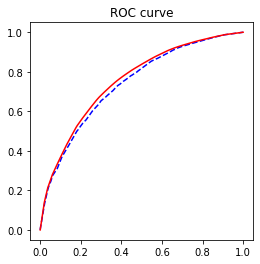

In [31]:
fpr_test, tpr_test, th_test = roc_curve(test.target_flag, test_p[:, 1])

fpr_train, tpr_train, th_train = roc_curve(train.target_flag, train_p[:, 1])

plt.figure(figsize=[4, 4])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()

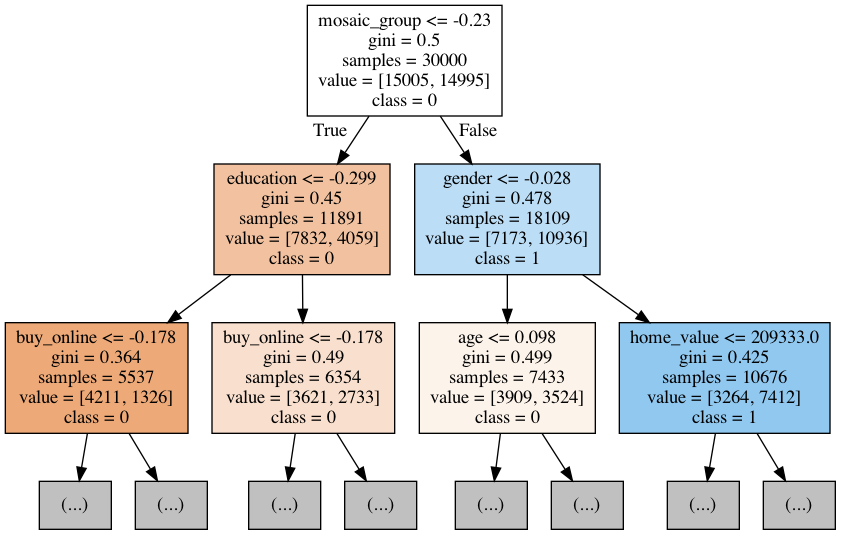

In [32]:
#可视化决策树
import pydotplus
from IPython.display import Image
import sklearn.tree as tree

dot_data = tree.export_graphviz(
    cv.best_estimator_, 
    out_file=None, 
    feature_names=train.columns[1:],
    max_depth=2,
    class_names=['0','1'],
    filled=True
) 
            
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 
# graph.write_pdf('response_decision_tree.pdf')

In [33]:
#将树的结构以决策规则输出
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [34]:
tree_to_code(cv.best_estimator_, train.columns[1:])

def tree(gender, education, home_value, age, buy_online, mosaic_group, marital, occupation, new_car):
  if mosaic_group <= -0.22991183958947659:
    if education <= -0.29864191077649593:
      if buy_online <= -0.1779557317495346:
        if gender <= -0.02771008014678955:
          return [[1338.  181.]]
        else:  # if gender > -0.02771008014678955
          if home_value <= 157472.0:
            return [[765. 169.]]
          else:  # if home_value > 157472.0
            if occupation <= 0.33799272775650024:
              return [[193.  77.]]
            else:  # if occupation > 0.33799272775650024
              return [[14. 21.]]
      else:  # if buy_online > -0.1779557317495346
        if age <= 0.09817798435688019:
          if gender <= -0.02771008014678955:
            return [[729. 180.]]
          else:  # if gender > -0.02771008014678955
            if home_value <= 102020.0:
              return [[252.  87.]]
            else:  # if home_value > 102020.0
              

In [35]:
cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=56,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [36]:
#使用组合方法，如GBDT方法来提高模型表现
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(train.ix[:, 1:], train.target_flag)
gbc_train_p = gbc.predict_proba(train.ix[:, 1:])
gbc_test_p = gbc.predict_proba(test.ix[:, 1:])

print(roc_auc_score(train.target_flag, gbc_train_p[:, 1]))
print(roc_auc_score(test.target_flag, gbc_test_p[:, 1]))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


0.7706014100668233
0.7576385376385376


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
 